# Notebook 3: Model Development & Training

**Objective:** Design and train a deep learning model that predicts both drum onsets and velocities from mel spectrograms.

This notebook implements our drum transcription neural network architecture, loss functions, and training pipeline. The model has dual heads for both onset detection and velocity prediction, allowing it to capture not just when a drum is hit but also how hard it's played.

## 1. Imports and Setup

Loading required libraries for model development, training, and evaluation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
import os
import time

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_SAVE_DIR = Path("../models")
MODEL_SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Drum mapping (same as in previous notebooks)
GM_DRUM_MAPPING = {
        36: "Kick",
        38: "Snare",
        42: "HiHat",
        47: "Tom",
        49: "Crash",
        51: "Ride"
    }

# Drum types constants
MAIN_DRUMS = list(GM_DRUM_MAPPING.keys())
MAIN_DRUM_NAMES = list(GM_DRUM_MAPPING.values())
N_DRUMS = len(MAIN_DRUMS)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_theme(style="whitegrid")

def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, f1_scores,
                   best_val_loss, patience_counter, filename):
    """Save a complete checkpoint that can be used to resume training."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'f1_scores': f1_scores,
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(filename, model, optimizer, scheduler=None):
    """Load a checkpoint to resume training."""
    if not Path(filename).exists():
        print(f"Checkpoint {filename} not found. Starting from scratch.")
        return 0, [], [], [], float('inf'), 0

    print(f"Loading checkpoint from {filename}")
    checkpoint = torch.load(filename, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    f1_scores = checkpoint['f1_scores']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']

    return start_epoch, train_losses, val_losses, f1_scores, best_val_loss, patience_counter

Using device: cuda


## 2. Create Dataset and DataLoader

Loading our preprocessed training examples (.npz files) and setting up the PyTorch data pipeline.

In [2]:
class DrumTranscriptionDataset(Dataset):
    """Dataset for loading preprocessed drum transcription examples."""

    def __init__(self, data_dir, split="train"):
        """
        Initialize the dataset.

        Args:
            data_dir: Directory containing the processed data
            split: Which dataset split to use ('train', 'validation', or 'test')
        """
        self.data_dir = Path(data_dir) / split
        self.file_list = list(self.data_dir.glob("*.npz"))

        if len(self.file_list) == 0:
            raise ValueError(f"No .npz files found in {self.data_dir}")

        print(f"Found {len(self.file_list)} examples in {split} set")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load the NPZ file
        data = np.load(self.file_list[idx])

        # Extract features and targets
        mel_spec = data["mel_spec"].astype(np.float32)  # [n_mels, n_frames]
        onset_target = data["onset_target"].astype(np.float32)  # [n_drums, n_frames]
        velocity_target = data["velocity_target"].astype(np.float32)  # [n_drums, n_frames]

        # Convert to tensors
        mel_spec = torch.from_numpy(mel_spec)
        onset_target = torch.from_numpy(onset_target)
        velocity_target = torch.from_numpy(velocity_target)

        return {
            "input": mel_spec,             # [n_mels, n_frames]
            "onset_target": onset_target,  # [n_drums, n_frames]
            "velocity_target": velocity_target,  # [n_drums, n_frames]
            "file_path": str(self.file_list[idx])
        }

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to the maximum length in the batch.
    """
    # Get max sequence length in this batch
    max_frames = max(item["input"].shape[1] for item in batch)

    # Initialize tensors for batched data
    batch_size = len(batch)
    n_mels = batch[0]["input"].shape[0]
    n_drums = batch[0]["onset_target"].shape[0]

    # Create padded tensors
    inputs = torch.zeros((batch_size, n_mels, max_frames))
    onset_targets = torch.zeros((batch_size, n_drums, max_frames))
    velocity_targets = torch.zeros((batch_size, n_drums, max_frames))
    file_paths = []

    # Fill in the data
    for i, item in enumerate(batch):
        frames = item["input"].shape[1]
        inputs[i, :, :frames] = item["input"]
        onset_targets[i, :, :frames] = item["onset_target"]
        velocity_targets[i, :, :frames] = item["velocity_target"]
        file_paths.append(item["file_path"])

    return {
        "input": inputs,
        "onset_target": onset_targets,
        "velocity_target": velocity_targets,
        "file_paths": file_paths
    }

# Create datasets
train_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="train")
val_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="validation")
test_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="test")

# Create dataloaders
batch_size = 4
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

Found 3187 examples in train set
Found 683 examples in validation set
Found 684 examples in test set


### 2.1 Inspect a Batch

Let's examine a batch of data to understand the input and target formats.

Input shape: torch.Size([4, 229, 6015])
Onset target shape: torch.Size([4, 6, 6015])
Velocity target shape: torch.Size([4, 6, 6015])


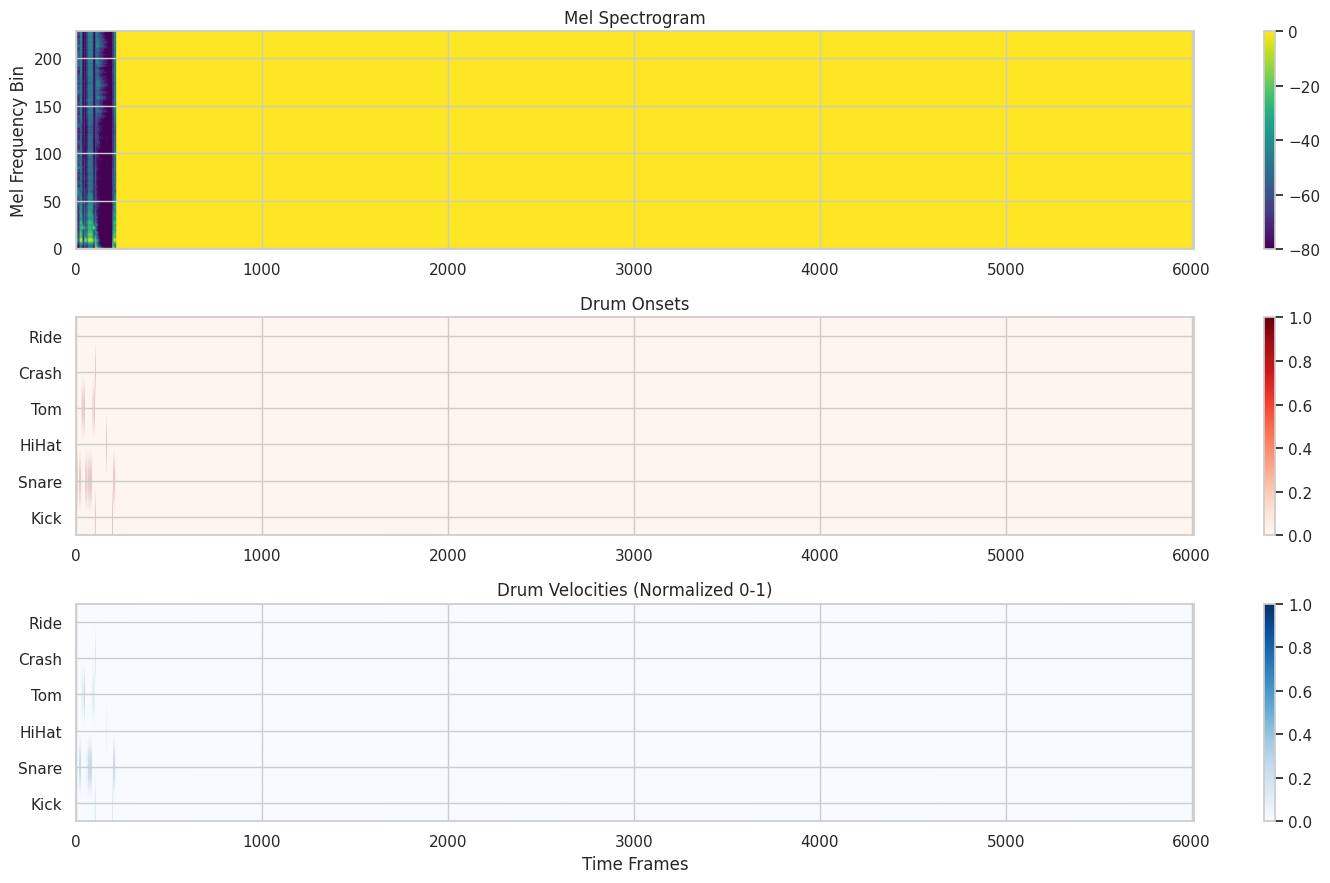

In [3]:
# Get a batch from the training loader
for batch in train_loader:
    inputs = batch["input"]
    onset_targets = batch["onset_target"]
    velocity_targets = batch["velocity_target"]

    print(f"Input shape: {inputs.shape}")  # [batch_size, n_mels, n_frames]
    print(f"Onset target shape: {onset_targets.shape}")  # [batch_size, n_drums, n_frames]
    print(f"Velocity target shape: {velocity_targets.shape}")  # [batch_size, n_drums, n_frames]

    # Plot one example
    idx = 0  # First example in batch
    plt.figure(figsize=(15, 9))

    # Plot mel spectrogram
    plt.subplot(3, 1, 1)
    plt.imshow(inputs[idx].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('Mel Spectrogram')
    plt.ylabel('Mel Frequency Bin')

    # Plot onset targets
    plt.subplot(3, 1, 2)
    plt.imshow(onset_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Reds')
    plt.colorbar()
    plt.title('Drum Onsets')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

    # Plot velocity targets
    plt.subplot(3, 1, 3)
    plt.imshow(velocity_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar()
    plt.title('Drum Velocities (Normalized 0-1)')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
    plt.xlabel('Time Frames')

    plt.tight_layout()
    plt.show()

    # Just examine one batch
    break

## 3. Define Model Architecture

Create our drum transcription model based on a CNN architecture with dual output heads.

In [4]:
class ConvBlock(nn.Module):
    """Convolutional block with batch normalization and ReLU activation."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DrumTranscriptionModel(nn.Module):
    """CNN model for drum transcription with dual output heads."""

    def __init__(self, n_mels=229, n_drums=6, use_lstm=True):
        """
        Initialize the model.

        Args:
            n_mels: Number of mel frequency bands in input
            n_drums: Number of drum types to detect
            use_lstm: Whether to use LSTM layers for temporal modeling
        """
        super(DrumTranscriptionModel, self).__init__()
        self.n_mels = n_mels
        self.n_drums = n_drums
        self.use_lstm = use_lstm

        # Feature extraction: convolutional layers
        self.conv_stack = nn.Sequential(
            # Layer 1: [B, 1, n_mels, T] -> [B, 32, n_mels//2, T]
            ConvBlock(1, 32),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 2: [B, 32, n_mels//2, T] -> [B, 64, n_mels//4, T]
            ConvBlock(32, 64),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 3: [B, 64, n_mels//4, T] -> [B, 128, n_mels//8, T]
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 4: [B, 128, n_mels//8, T] -> [B, 128, n_mels//16, T]
            ConvBlock(128, 128),
            nn.MaxPool2d(kernel_size=(2, 1))   # Frequency pooling
        )

        # Calculate feature dimensions after CNN
        self.cnn_output_dim = 128 * (n_mels // 16)

        # Optional: Bi-directional LSTM layer for temporal modeling
        if self.use_lstm:
            self.lstm = nn.LSTM(
                input_size=self.cnn_output_dim,
                hidden_size=256,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            feature_dim = 512  # bidirectional LSTM output
        else:
            feature_dim = self.cnn_output_dim

        # Onset detection head
        self.onset_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_drums),
            nn.Sigmoid()  # Binary classification for each drum
        )

        # Velocity prediction head
        self.velocity_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_drums),
            # No activation - regression task
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape [batch_size, n_mels, n_frames]

        Returns:
            Tuple of (onset_predictions, velocity_predictions)
        """
        batch_size = x.shape[0]

        # Add channel dimension for CNN input [B, 1, n_mels, T]
        x = x.unsqueeze(1)

        # Pass through CNN stack
        x = self.conv_stack(x)

        # Reshape for RNN/Linear: [batch_size, time_steps, features]
        x = x.permute(0, 3, 1, 2)  # [B, T, C, F]
        x = x.reshape(batch_size, x.shape[1], -1)  # [B, T, C*F]

        # Optional: Pass through LSTM for temporal modeling
        if self.use_lstm:
            x, _ = self.lstm(x)  # [B, T, 2*hidden_size]

        # Apply the output heads
        onset_pred = self.onset_head(x)  # [B, T, n_drums]
        velocity_pred = self.velocity_head(x)  # [B, T, n_drums]

        # Reshape to match target format [B, n_drums, T]
        onset_pred = onset_pred.transpose(1, 2)
        velocity_pred = velocity_pred.transpose(1, 2)

        return onset_pred, velocity_pred

# Create model instance
model = DrumTranscriptionModel(n_mels=229, n_drums=N_DRUMS, use_lstm=True)
model = model.to(device)

# Print model summary
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(model)

Model parameters: 4,572,236
DrumTranscriptionModel(
  (conv_stack): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=

## 4. Define Loss Functions

We'll define a combined loss function that handles both onset detection (binary cross entropy) and velocity prediction (mean squared error).

In [5]:
def combined_loss_function(
    onset_pred,
    velocity_pred,
    onset_target,
    velocity_target,
    onset_weight=0.8
):
    """
    Combined loss for both onset detection and velocity prediction.

    Args:
        onset_pred: Onset predictions [B, n_drums, T]
        velocity_pred: Velocity predictions [B, n_drums, T]
        onset_target: Onset targets [B, n_drums, T]
        velocity_target: Velocity targets [B, n_drums, T]
        onset_weight: Weight for onset loss (velocity_weight = 1 - onset_weight)

    Returns:
        Tuple of (combined_loss, onset_loss, velocity_loss)
    """
    # Binary cross entropy for onset detection
    onset_loss = F.binary_cross_entropy(onset_pred, onset_target)

    # Only calculate velocity loss for positive onsets to match training target
    # Create a mask where onsets exist
    mask = onset_target > 0

    if mask.sum() > 0:  # If there are any positive onsets in this batch
        velocity_loss = F.mse_loss(velocity_pred[mask], velocity_target[mask])
    else:
        velocity_loss = torch.tensor(0.0, device=onset_pred.device)

    # Combine losses with specified weighting
    velocity_weight = 1.0 - onset_weight
    combined = onset_weight * onset_loss + velocity_weight * velocity_loss

    return combined, onset_loss, velocity_loss

## 5. Training Loop

Define functions to train the model and evaluate it on validation data.

In [ ]:
def train_epoch(model, train_loader, optimizer, device, onset_weight=0.8):
    """Train the model for one epoch."""
    model.train()
    epoch_loss = 0
    epoch_onset_loss = 0
    epoch_velocity_loss = 0
    batch_count = 0

    # Loop over batches
    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        # Move data to device
        inputs = batch["input"].to(device)
        onset_target = batch["onset_target"].to(device)
        velocity_target = batch["velocity_target"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        onset_pred, velocity_pred = model(inputs)

        # Calculate loss
        loss, onset_loss, velocity_loss = combined_loss_function(
            onset_pred, velocity_pred, onset_target, velocity_target, onset_weight
        )

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        epoch_onset_loss += onset_loss.item()
        epoch_velocity_loss += velocity_loss.item()
        batch_count += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'o_loss': f"{onset_loss.item():.4f}",
            'v_loss': f"{velocity_loss.item():.4f}"
        })

    # Calculate average losses
    return {
        'loss': epoch_loss / batch_count,
        'onset_loss': epoch_onset_loss / batch_count,
        'velocity_loss': epoch_velocity_loss / batch_count
    }

def validate(model, val_loader, device, onset_weight=0.8):
    """Evaluate the model on validation data."""
    model.eval()
    val_loss = 0
    val_onset_loss = 0
    val_velocity_loss = 0
    batch_count = 0

    # For computing onset detection metrics
    all_onset_preds = []
    all_onset_targets = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating")
        for batch in progress_bar:
            # Move data to device
            inputs = batch["input"].to(device)
            onset_target = batch["onset_target"].to(device)
            velocity_target = batch["velocity_target"].to(device)

            # Forward pass
            onset_pred, velocity_pred = model(inputs)

            # Calculate loss
            loss, onset_loss, velocity_loss = combined_loss_function(
                onset_pred, velocity_pred, onset_target, velocity_target, onset_weight
            )

            # Update metrics
            val_loss += loss.item()
            val_onset_loss += onset_loss.item()
            val_velocity_loss += velocity_loss.item()
            batch_count += 1

            # Store predictions for F1 calculation
            all_onset_preds.append(onset_pred.detach().cpu().numpy())
            all_onset_targets.append(onset_target.detach().cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'val_loss': f"{loss.item():.4f}",
                'o_loss': f"{onset_loss.item():.4f}",
                'v_loss': f"{velocity_loss.item():.4f}"
            })

    # Calculate F1 score for onset detection
    threshold = 0.5
    all_preds = np.concatenate([p.reshape(-1) for p in all_onset_preds])
    all_targets = np.concatenate([t.reshape(-1) for t in all_onset_targets])

    # Binarize predictions using threshold
    binary_preds = (all_preds > threshold).astype(int)

    # Calculate metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, binary_preds, average='binary', zero_division=0
    )

    # Calculate average losses
    return {
        'loss': val_loss / batch_count,
        'onset_loss': val_onset_loss / batch_count,
        'velocity_loss': val_velocity_loss / batch_count,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_model(model, train_loader, val_loader, device,
                learning_rate=0.001, epochs=30, patience=5, onset_weight=0.8,
                resume_from=None):
    """Train the model with early stopping, learning rate scheduling, and checkpointing."""

    # Initialize optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Track metrics
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    f1_scores = []
    start_epoch = 0

    # Create checkpoint directory if it doesn't exist
    checkpoint_dir = MODEL_SAVE_DIR / 'checkpoints'
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    # Resume training if a checkpoint is provided
    if resume_from:
        start_epoch, train_losses, val_losses, f1_scores, best_val_loss, patience_counter = load_checkpoint(
            resume_from, model, optimizer, scheduler
        )
        print(f"Resuming training from epoch {start_epoch}")

    # Main training loop
    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        start_time = time.time()

        # Train for one epoch
        train_metrics = train_epoch(model, train_loader, optimizer, device, onset_weight)
        train_loss = train_metrics['loss']
        train_losses.append(train_loss)

        # Validate
        val_metrics = validate(model, val_loader, device, onset_weight)
        val_loss = val_metrics['loss']
        val_losses.append(val_loss)
        f1_scores.append(val_metrics['f1'])

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f} (Onset: {train_metrics['onset_loss']:.4f}, Velocity: {train_metrics['velocity_loss']:.4f})")
        print(f"Val Loss: {val_loss:.4f} (Onset: {val_metrics['onset_loss']:.4f}, Velocity: {val_metrics['velocity_loss']:.4f})")
        print(f"F1 Score: {val_metrics['f1']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")

        # Save regular checkpoint after each epoch
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pt"
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_losses, val_losses,
            f1_scores, best_val_loss, patience_counter, checkpoint_path
        )

        # Also save latest checkpoint (overwriting the previous one)
        latest_path = checkpoint_dir / "checkpoint_latest.pt"
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_losses, val_losses,
            f1_scores, best_val_loss, patience_counter, latest_path
        )

        # Automatically download checkpoints every few epochs if in Colab
        if 'google.colab' in sys.modules and (epoch % 5 == 0 or epoch == epochs-1):
            try:
                from google.colab import files
                print("\nDownloading checkpoint files to prevent data loss...")

                # Download best model if it exists
                best_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'
                if best_model_path.exists():
                    files.download(str(best_model_path))
                    print("Downloaded best model")

                # Download latest checkpoint
                files.download(str(latest_path))
                print("Downloaded latest checkpoint")

                # Continue training without interruption
            except Exception as e:
                print(f"Could not download automatically: {e}")
                print("Consider manually running the download_checkpoints() function in a separate cell")

        # Check for improvement and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save the best model
            best_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'f1_score': val_metrics['f1'],
            }, best_model_path)

            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs!")
                break

    # Save the final model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'f1_score': val_metrics['f1'],
    }, MODEL_SAVE_DIR / 'drum_transcription_final.pt')

    # Plot training history
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(f1_scores, label='F1 Score', color='green')
    plt.title('F1 Score History')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, f1_scores

## 6. Train the Model

Execute the training process. This will take some time depending on hardware.

In [ ]:
# Set hyperparameters
learning_rate = 0.001
epochs = 30
patience = 5
onset_weight = 0.8

# To resume training from the latest checkpoint
# latest_checkpoint = MODEL_SAVE_DIR / 'checkpoints' / 'checkpoint_latest.pt'

model, train_losses, val_losses, f1_scores = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    learning_rate=learning_rate,
    epochs=epochs,
    patience=patience,
    onset_weight=onset_weight,
    # resume_from=latest_checkpoint if Path(latest_checkpoint).exists() else None
)


Epoch 1/30


Training:   0%|          | 0/797 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 7. Evaluate on Test Set

Evaluate the best model on the test set to get an unbiased measure of performance.

In [ ]:
# Load best model
best_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'
checkpoint = torch.load(best_model_path, map_location=device)

# Create a new model instance and load state
best_model = DrumTranscriptionModel(n_mels=229, n_drums=N_DRUMS, use_lstm=True)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation loss: {checkpoint['val_loss']:.4f}")

# Evaluate on test set
test_metrics = validate(best_model, test_loader, device, onset_weight=onset_weight)

print("\nTest Set Evaluation:")
print(f"Test Loss: {test_metrics['loss']:.4f} (Onset: {test_metrics['onset_loss']:.4f}, Velocity: {test_metrics['velocity_loss']:.4f})")
print(f"F1 Score: {test_metrics['f1']:.4f}, Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")

## 8. Visualize Predictions

Let's visualize some predictions from the test set to qualitatively assess model performance.

In [ ]:
def visualize_predictions(model, data_loader, device, threshold=0.5, num_samples=3):
    """Visualize model predictions on a few samples."""
    model.eval()

    samples_seen = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["input"].to(device)
            onset_targets = batch["onset_target"]
            velocity_targets = batch["velocity_target"]
            file_paths = batch["file_paths"]

            # Forward pass
            onset_preds, velocity_preds = model(inputs)
            onset_preds = onset_preds.cpu()
            velocity_preds = velocity_preds.cpu()

            # Loop through each item in the batch
            for i in range(min(inputs.size(0), num_samples - samples_seen)):
                # Get a single sample
                input_spec = inputs[i].cpu()
                onset_target = onset_targets[i]
                velocity_target = velocity_targets[i]
                onset_pred = onset_preds[i]
                velocity_pred = velocity_preds[i]

                # Create binary onset predictions
                binary_onset = (onset_pred > threshold).float()

                # Create a mask for velocities based on predicted onsets
                masked_velocity_pred = velocity_pred * binary_onset

                # Visualize
                plt.figure(figsize=(15, 10))

                # Plot input spectrogram
                plt.subplot(4, 1, 1)
                plt.imshow(input_spec.numpy(), aspect='auto', origin='lower', cmap='viridis')
                plt.colorbar()
                plt.title('Mel Spectrogram')
                plt.ylabel('Mel Bin')

                # Plot ground truth onsets
                plt.subplot(4, 1, 2)
                plt.imshow(onset_target.numpy(), aspect='auto', origin='lower', cmap='Reds')
                plt.colorbar()
                plt.title('Ground Truth Onsets')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted onsets (binary)
                plt.subplot(4, 1, 3)
                plt.imshow(binary_onset.numpy(), aspect='auto', origin='lower', cmap='OrRd')
                plt.colorbar()
                plt.title(f'Predicted Onsets (threshold={threshold})')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted velocities (masked by onset predictions)
                plt.subplot(4, 1, 4)
                plt.imshow(masked_velocity_pred.numpy(), aspect='auto', origin='lower', cmap='Blues')
                plt.colorbar()
                plt.title('Predicted Velocities (only where onset predicted)')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
                plt.xlabel('Time Frame')

                plt.tight_layout()
                plt.show()

                # Show the file path of this example
                print(f"File: {file_paths[i]}")

                samples_seen += 1

            if samples_seen >= num_samples:
                break

# Visualize some predictions
visualize_predictions(best_model, test_loader, device, threshold=0.5, num_samples=3)

## 9. Conclusion

In this notebook, we've successfully built and trained a deep learning model for drum transcription. The model has dual outputs: one for detecting drum onsets (when a drum is hit) and another for predicting the velocity (how hard it's hit).

**Key accomplishments:**

1. Created a PyTorch dataset for loading processed training examples
2. Designed a CNN/CRNN architecture with dual output heads
3. Implemented a combined loss function for multi-task learning
4. Trained the model with early stopping and learning rate scheduling
5. Evaluated performance using appropriate metrics
6. Visualized predictions alongside ground truth

The F1 score on the test set gives us an idea of how well the model is detecting drum hits. In our next notebook, we'll explore how to convert these predictions into MIDI files and evaluate the full transcription system.